In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, csv file I/O (e.g. pd.read_csv)
import os # deal with os primitives
import time # time-related functions
import matplotlib.pyplot as plt # plots
import pickle # object serialization
from collections import Counter # dict subclass for counting hashable items
from tqdm import tqdm # iterable object
import random # random values generator
import seaborn as sns # prettier plots
import torch # main package for PyTorch
import torch.utils.data as data_utils # access data sets, including pre-processing, loading, and splitting
from torch.utils.data import random_split # randomly split a dataset 
import torch.optim as optim # optimization algorithms
import torch.nn as nn # build neural network (layers, activations, loss functions)
import torch.nn.functional as F # functions used to build neural network
from torchsummary import summary # print the summary of a neural network model
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts # scheduler used to adjust the learning rate
from torch.utils.tensorboard.writer import SummaryWriter # nn log writer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import torch

# set the random seed for reproducibility
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
np.random.seed(1111)
random.seed(1111)


In [2]:
import pandas as pd

# Load the train set
df_train = pd.read_pickle("df_train.pkl")

# Load the test set
df_test = pd.read_pickle("df_test.pkl")

# Define a function to extract the matrix and target from a DataFrame
def extract_matrix_and_target(df):
    matrix_column = "graph"
    target_column = "label_time"

    matrices = df[matrix_column].tolist()
    targets = df[target_column].tolist()

    return matrices, targets

# Extract matrix and target for train set
train_graphs, train_targets = extract_matrix_and_target(df_train)

# Extract matrix and target for test set
test_graphs, test_targets = extract_matrix_and_target(df_test)

# Display the first matrix and target in the train set
print("First matrix in train set:")
print(train_graphs[0])

print("\nFirst target in train set:")
print(train_targets[0])


First matrix in train set:
Graph with 19 nodes and 11 edges

First target in train set:
dfs


In [3]:
import networkx as nx
import numpy as np
import statistics
import math

def calculate_graph_size_features(graph):
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)

    return {
        'nodes': num_nodes,
        'edges': num_edges,
        'ratio_n_m': num_nodes / num_edges if num_edges != 0 else 0,
        'ratio_m_n': num_edges / num_nodes if num_nodes != 0 else 0,
        'density': 2 * num_edges / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0
    }

def calculate_node_degree_stats(graph):
    degrees = list(dict(graph.degree()).values())
    degrees_np = np.array(degrees)

    unique_degrees, counts = np.unique(degrees_np, return_counts=True)

    entropy_term = np.fromiter((p * np.log2(p) for p in (np.count_nonzero(degrees_np == x) / len(degrees_np) for x in set(degrees_np))), dtype=float)
    
    return {
        'min_degree': np.min(degrees_np),
        'max_degree': np.max(degrees_np),
        'mean_degree': np.mean(degrees_np),
        'median_degree': np.median(degrees_np),
        'q0.25_degree': np.percentile(degrees_np, 25),
        'q0.75_degree': np.percentile(degrees_np, 75),
        'variation_coefficient_degree': np.std(degrees_np) / np.mean(degrees_np),
        'entropy_degree': -np.sum(entropy_term)
    }

def calculate_maximal_clique_stats(graph, num_nodes):
    cliques = list(map(len, nx.enumerate_all_cliques(graph)))
    return {
        'normalized_min_clique_size': min(cliques) / num_nodes,
        'normalized_max_clique_size': max(cliques) / num_nodes,
        'normalized_median_clique_size': statistics.median(cliques) / num_nodes,
        'normalized_q0.25_clique_size': statistics.quantiles(cliques, n=4)[0] / num_nodes,
        'normalized_q0.75_clique_size': statistics.quantiles(cliques, n=4)[2] / num_nodes,
        'normalized_variation_coefficient_clique_size': statistics.stdev(cliques) / statistics.mean(cliques),
        'normalized_entropy_clique_size': -sum(p * math.log2(p) for p in (cliques.count(x) / len(cliques) for x in set(cliques))) / num_nodes
    }

In [4]:
def calculate_graph_size_features(graph):
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)

    # Check for division by zero
    if num_edges != 0 and num_nodes != 0:
        return {
            'nodes': num_nodes,
            'edges': num_edges,
            'ratio_n_m': num_nodes / num_edges,
            'ratio_m_n': num_edges / num_nodes,
            'density': 2 * num_edges / (num_nodes * (num_nodes - 1))
        }
    else:
        # Handle the case where either num_edges or num_nodes is zero
        return {
            'nodes': num_nodes,
            'edges': num_edges,
            'ratio_n_m': 0,
            'ratio_m_n': 0,
            'density': 0
        }

def calculate_node_degree_stats(graph):
    degrees = list(dict(graph.degree()).values())
    degrees_np = np.array(degrees)

    # Check for diversity in degrees
    if len(set(degrees_np)) > 1:
        unique_degrees, counts = np.unique(degrees_np, return_counts=True)

        entropy_term = np.fromiter((p * np.log2(p) for p in (np.count_nonzero(degrees_np == x) / len(degrees_np) for x in set(degrees_np))), dtype=float)

        return {
            'min_degree': np.min(degrees_np),
            'max_degree': np.max(degrees_np),
            'mean_degree': np.mean(degrees_np),
            'median_degree': np.median(degrees_np),
            'q0.25_degree': np.percentile(degrees_np, 25),
            'q0.75_degree': np.percentile(degrees_np, 75),
            'variation_coefficient_degree': np.std(degrees_np) / np.mean(degrees_np),
            'entropy_degree': -np.sum(entropy_term)
        }
    else:
        # Handle the case where there is no diversity in degrees
        return {
            'min_degree': 0,
            'max_degree': 0,
            'mean_degree': 0,
            'median_degree': 0,
            'q0.25_degree': 0,
            'q0.75_degree': 0,
            'variation_coefficient_degree': 0,
            'entropy_degree': 0
        }


def calculate_maximal_clique_stats(graph, num_nodes):
    cliques = list(map(len, nx.enumerate_all_cliques(graph)))

    # Check for diversity in cliques
    if len(set(cliques)) > 1:
        return {
            'normalized_min_clique_size': min(cliques) / num_nodes,
            'normalized_max_clique_size': max(cliques) / num_nodes,
            'normalized_median_clique_size': statistics.median(cliques) / num_nodes,
            'normalized_q0.25_clique_size': statistics.quantiles(cliques, n=4)[0] / num_nodes,
            'normalized_q0.75_clique_size': statistics.quantiles(cliques, n=4)[2] / num_nodes,
            'normalized_variation_coefficient_clique_size': statistics.stdev(cliques) / statistics.mean(cliques),
            'normalized_entropy_clique_size': -sum(p * math.log2(p) for p in (cliques.count(x) / len(cliques) for x in set(cliques))) / num_nodes
        }
    else:
        # Handle the case where there is no diversity in cliques
        return {
            'normalized_min_clique_size': 0,
            'normalized_max_clique_size': 0,
            'normalized_median_clique_size': 0,
            'normalized_q0.25_clique_size': 0,
            'normalized_q0.75_clique_size': 0,
            'normalized_variation_coefficient_clique_size': 0,
            'normalized_entropy_clique_size': 0
        }


In [5]:
# Loop through each graph in the train set
train_graph_metrics = []
for graph, target in zip(train_graphs, train_targets):
    size_features = calculate_graph_size_features(graph)
    degree_stats = calculate_node_degree_stats(graph)
    clique_stats = calculate_maximal_clique_stats(graph, len(graph.nodes()))

    # Combine the metrics into one dictionary
    graph_metrics = {**size_features, **degree_stats, **clique_stats, 'target': target}
    
    train_graph_metrics.append(graph_metrics)

# Loop through each graph in the test set
test_graph_metrics = []
for graph, target in zip(test_graphs, test_targets):
    graph_array = nx.to_numpy_array(graph)
    size_features = calculate_graph_size_features(graph)
    degree_stats = calculate_node_degree_stats(graph)
    clique_stats = calculate_maximal_clique_stats(graph, graph_array.shape[0])  # Use graph_array.shape[0] for the number of nodes
    
    # Combine the metrics into one dictionary
    graph_metrics = {**size_features, **degree_stats, **clique_stats, 'target': target}
    
    test_graph_metrics.append(graph_metrics)

# Convert train_graph_metrics and test_graph_metrics to DataFrames
train_df = pd.DataFrame(train_graph_metrics)
test_df = pd.DataFrame(test_graph_metrics)


In [6]:
# Display the first few rows of each DataFrame for verification
print("Train DataFrame:")
train_df.head()


Train DataFrame:


,nodes,edges,ratio_n_m,ratio_m_n,density,min_degree,max_degree,mean_degree,median_degree,q0.25_degree,...,variation_coefficient_degree,entropy_degree,normalized_min_clique_size,normalized_max_clique_size,normalized_median_clique_size,normalized_q0.25_clique_size,normalized_q0.75_clique_size,normalized_variation_coefficient_clique_size,normalized_entropy_clique_size,target
0,19,11,1.727273,0.578947,0.064327,0,3,1.157895,1.0,0.0,...,0.897655,1.871019,0.052632,0.157895,0.052632,0.052632,0.105263,0.397478,0.059110,dfs
1,34,130,0.261538,3.823529,0.231729,3,12,7.647059,7.0,6.0,...,0.316975,3.051602,0.029412,0.117647,0.058824,0.058824,0.088235,0.324626,0.046827,best_first_search
2,68,364,0.186813,5.352941,0.159789,3,18,10.705882,11.0,9.0,...,0.259815,3.374558,0.014706,0.058824,0.029412,0.029412,0.044118,0.301528,0.022069,best_first_search
3,58,122,0.475410,2.103448,0.073805,1,10,4.206897,4.0,3.0,...,0.472859,2.907696,0.017241,0.051724,0.034483,0.017241,0.034483,0.319693,0.020953,best_first_search
4,96,131,0.732824,1.364583,0.028728,0,9,2.729167,2.0,1.0,...,0.678273,2.686679,0.010417,0.031250,0.020833,0.010417,0.020833,0.330712,0.011580,bidirectional_search


In [7]:
print("\nTest DataFrame:")
test_df.head()


Test DataFrame:


,nodes,edges,ratio_n_m,ratio_m_n,density,min_degree,max_degree,mean_degree,median_degree,q0.25_degree,...,variation_coefficient_degree,entropy_degree,normalized_min_clique_size,normalized_max_clique_size,normalized_median_clique_size,normalized_q0.25_clique_size,normalized_q0.75_clique_size,normalized_variation_coefficient_clique_size,normalized_entropy_clique_size,target
0,41,85,0.482353,2.073171,0.103659,1,10,4.146341,4.0,3.0,...,0.486922,2.737474,0.024390,0.073171,0.048780,0.024390,0.048780,0.329137,0.031053,best_first_search
1,31,52,0.596154,1.677419,0.111828,1,6,3.354839,3.0,2.0,...,0.493860,2.543065,0.032258,0.096774,0.064516,0.032258,0.064516,0.350882,0.042649,best_first_search
2,30,83,0.361446,2.766667,0.190805,2,10,5.533333,5.5,4.0,...,0.372521,2.806239,0.033333,0.100000,0.066667,0.066667,0.066667,0.322118,0.045542,bidirectional_search
3,187,3046,0.061392,16.288770,0.175148,21,46,32.577540,33.0,29.5,...,0.148518,4.143077,0.005348,0.026738,0.016043,0.010695,0.016043,0.246461,0.008123,best_first_search
4,105,141,0.744681,1.342857,0.025824,0,9,2.685714,2.0,1.0,...,0.658716,2.702194,0.009524,0.028571,0.019048,0.009524,0.019048,0.330766,0.010532,bidirectional_search


In [8]:
test_df.columns

Index(['nodes', 'edges', 'ratio_n_m', 'ratio_m_n', 'density', 'min_degree',
       'max_degree', 'mean_degree', 'median_degree', 'q0.25_degree',
       'q0.75_degree', 'variation_coefficient_degree', 'entropy_degree',
       'normalized_min_clique_size', 'normalized_max_clique_size',
       'normalized_median_clique_size', 'normalized_q0.25_clique_size',
       'normalized_q0.75_clique_size',
       'normalized_variation_coefficient_clique_size',
       'normalized_entropy_clique_size', 'target'],
      dtype='object')

In [9]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("[i] USING CUDA")
    else:
        device = torch.device('cpu') # don't have GPU 
        print("[i] USING CPU")
    return device

device = get_device() #setting up the DL device

[i] USING CUDA


In [10]:
#Choosing the number or epochs and the learning rate
num_epochs = 1000
batch_size = 256
mini_batch_size = 64

In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from imblearn.over_sampling import SMOTE

# Assuming train_df and test_df are your dataframes
# Assuming 'target' is your target column name

# Combine train and test datasets for uniform preprocessing
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Separate features and target
X = combined_df.drop('target', axis=1)
y = combined_df['target']

# Define features to be normalized and one-hot encoded
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform data
X_transformed = preprocessor.fit_transform(X)

# Split into train, validation, and test sets
# 90 train 10 validation
# 20% test
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=42)

print(y_train)
# Calculate class weight
class_sample_count = np.array([y_train.value_counts()[c] for c in y_train.unique()])

print(class_sample_count)

# Count the number of samples in the minority class
minority_class_samples = min(class_sample_count)

# Set n_neighbors to a value less than or equal to the number of samples in the minority class
n_neighbors = min(5, minority_class_samples - 1)

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', k_neighbors=n_neighbors)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train.values)


# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_smote, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# One-hot encode the target column
y_train_onehot = pd.get_dummies(y_train_smote)
y_val_onehot = pd.get_dummies(y_val)
y_test_onehot = pd.get_dummies(y_test)

# Convert one-hot encoded targets to PyTorch tensors
y_train_tensor = torch.tensor(y_train_onehot.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_onehot.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_onehot.values, dtype=torch.float32)

# Calculate class weights for the training set

weight = 1. / class_sample_count
samples_weight = np.array([weight[c] for c in range(y_train_onehot.shape[1])])

# Create a WeightedRandomSampler for the training set
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create PyTorch dataloaders with WeightedRandomSampler for the training set
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


3489    best_first_search
948     best_first_search
2132    best_first_search
4316    best_first_search
4599    best_first_search
              ...        
3200    best_first_search
617     best_first_search
1992    best_first_search
3301    best_first_search
3687    best_first_search
Name: target, Length: 3600, dtype: object
[2481  402  415   83   82  132    5]


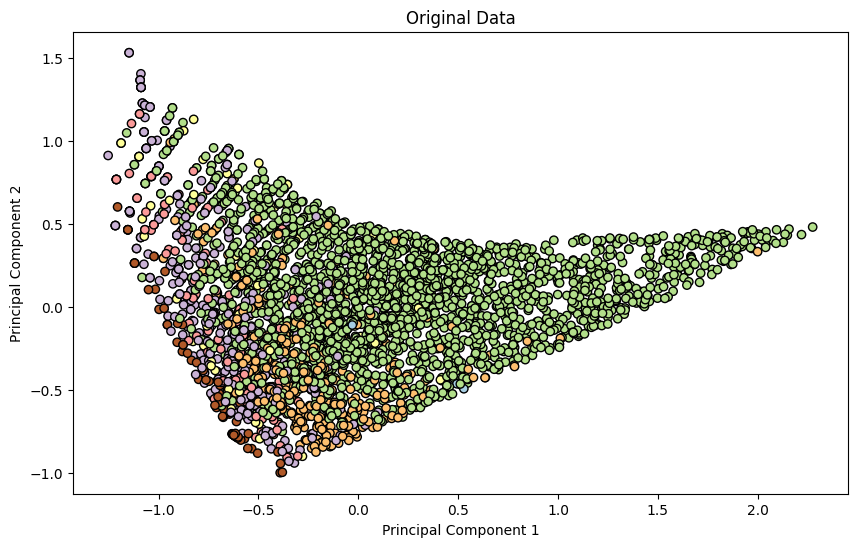

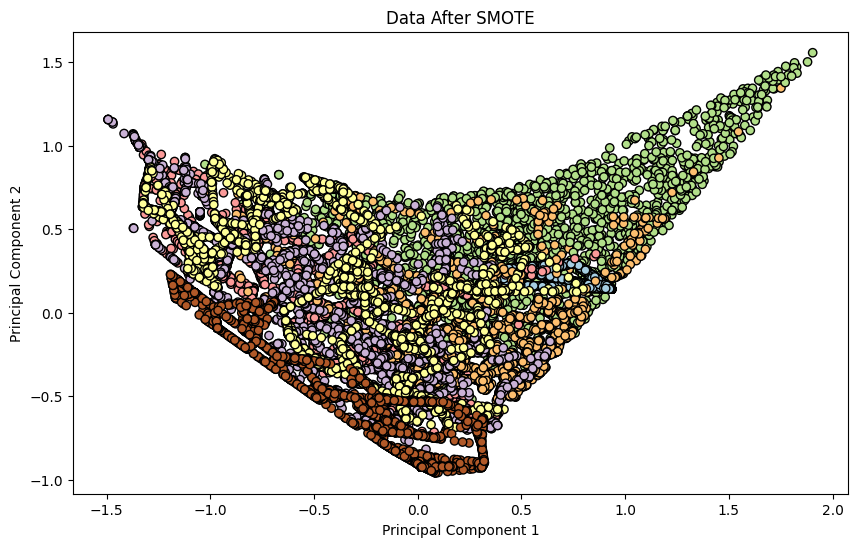

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Function to plot the data using PCA
def plot_data(X, y, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    label_encoder = LabelEncoder()
    y_numeric = label_encoder.fit_transform(y)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_numeric, cmap=plt.cm.Paired, edgecolor='k')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Plot the original data
plot_data(X_train, y_train, title='Original Data')

# Plot the data after applying SMOTE
plot_data(X_train_smote, y_train_smote, title='Data After SMOTE')


In [13]:
num_classes = len(np.unique(y_train))
input_size = X_train.shape[1]

In [14]:
# Initialize counters for each class
class_counts = [0] * y_train_tensor.shape[1]

# Iterate through the entire training dataset without using the sampler
for batch_idx, (_, y_one_hot) in enumerate(DataLoader(train_dataset, batch_size=batch_size, shuffle=False)):
    # Convert one-hot encoded labels to class indices
    y = torch.argmax(y_one_hot, dim=1)

    # Update class counts for each batch
    for class_idx in range(y_train_tensor.shape[1]):
        class_counts[class_idx] += len(torch.where(y == class_idx)[0])

# Print cumulative count of elements in different classes
print("Cumulative Class Counts:", class_counts)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler)

Cumulative Class Counts: [2481, 2481, 2481, 2481, 2481, 2481, 2481]


In [15]:
import time
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
# define training function

# implement early stopping for training function
# from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss <= self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print(f"[i] Validation Loss Increased - Early Stop!")
                print(
                    f"--- {validation_loss} > {self.min_validation_loss + self.min_delta} ---")
                return True
        return False


def train(net, train_loader, validation_loader, num_epochs, batch_size, mini_batch_size, optimizer, lr_scheduler, criterion, earlystop_patience=1, earlystop_min_delta=1e-5, name=""):
    # Save the loss into a dataframe
    losses = pd.DataFrame(index=list(range(num_epochs)), columns=[
                          'running_loss', 'train_loss', 'valid_loss'])
    min_validation_loss = np.inf

    # Use a summary writer to check loss in real time
    current_time = time.strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter(
        f'runs/tensorboard/{current_time}_{(net.__class__.__name__).lower()}_{name}')

    # Set early stopping parameters
    # from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
    early_stopping = EarlyStopper(
        patience=earlystop_patience, min_delta=earlystop_min_delta)

    start_time_epoch = time.time()

    net.train()
    net.to(device)  # Move the model to the specified device

    for epoch in range(num_epochs):  # Looping over the dataset

        running_loss = 0.0
        validation_loss = 0.0
        train_loss = 0.0

        
        net.train()  # Set the model to training mode

        for i, data in enumerate(train_loader):
            start_time_mini_batch = time.time()
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Setting the parameter gradients to zero
            outputs = net(inputs)  # Forward pass

            labels = labels.float()

            loss = criterion(outputs, labels)  # Applying the criterion
            loss.backward()  # Backward pass
            optimizer.step()  # Optimization step

            running_loss += loss.item()  # Updating the running loss
            train_loss += loss.item()

            if i % mini_batch_size == mini_batch_size - 1:  # Printing the running loss
                print(f"[epoch: {epoch + 1}, mini-batch: {i + 1}, time-taken: {round(time.time() - start_time_mini_batch, 3)} sec] loss: {round(running_loss / mini_batch_size, 6)} ")

                # write on the summary writer
                writer.add_scalar(
                    'Loss/Running', running_loss / mini_batch_size, i)

                running_loss = 0.0
                start_time_mini_batch = time.time()


        net.eval().to(device)

        # Inside the validation loop
        with torch.no_grad():
            net.eval()  # Set the model to evaluation mode
            all_labels = []
            all_outputs = []

            for i, data in enumerate(validation_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)  # Forward pass

                loss = criterion(outputs, labels) # Applying the criterion
                validation_loss += loss.item() # Check the loss

                # Use argmax to get the index of the predicted class
                predicted_class = torch.argmax(outputs, dim=1)

                # Append predictions and labels for accuracy calculation
                all_outputs.extend(predicted_class.cpu().numpy())
                all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

            # Convert lists to numpy arrays for easier computation
            all_labels = np.array(all_labels)
            all_outputs = np.array(all_outputs)

            val_accuracy = accuracy_score(all_labels, all_outputs)
            val_precision = precision_score(all_labels, all_outputs, average='weighted', zero_division=1.0)
            val_recall = recall_score(all_labels, all_outputs, average='weighted', zero_division=1.0)
            val_f1 = f1_score(all_labels, all_outputs, average='weighted', zero_division=1.0)

            # Print or log the accuracy and validation loss
            print(f'+++ [\033[1mepoch: {epoch + 1}\033[0m, validation - \033[91maccuracy: {val_accuracy:.5f}\033[0m, \033[93mprecision: {val_precision:.5f}\033[0m, \033[94mrecall: {val_recall:.5f}\033[0m, \033[95mf1-score: {val_f1:.5f}\033[0m] +++')

        # Switch back to training mode for the next epoch
        net.train().to(device)

        print('+++ [epoch: %d, training loss: %.5f, validation loss: %.5f] +++' %
              (epoch + 1,
               train_loss / len(train_loader),
               validation_loss / len(validation_loader)))

        print(
            f"--- time-taken for epoch {epoch+1}: {round(time.time() - start_time_epoch, 3)} seconds ---")
        start_time_epoch = time.time()

        # Saving the loss
        losses.at[epoch, 'running_loss'] = running_loss
        losses.at[epoch, 'train_loss'] = train_loss
        losses.at[epoch, 'valid_loss'] = validation_loss

        # Write on the summary writer
        writer.add_scalar('Loss/Train', train_loss / len(train_loader), epoch)
        writer.add_scalar('Loss/Validation', validation_loss /
                          len(validation_loader), epoch)

        # Update the learning rate
        if lr_scheduler.__class__.__name__ == "CosineAnnealingWarmRestarts" and lr_scheduler is not None:
            print(f"\033[90m--- current LR: {round(lr_scheduler.get_last_lr()[0], 9)} ---\033[0m")
            lr_scheduler.step()  # step scheduler learning rate

        if min_validation_loss > (validation_loss / len(validation_loader)):
            print(f'\033[92m+++ [validation loss decreased ({min_validation_loss:.9f} -> {(validation_loss / len(validation_loader)):.9f}), saving the model ...] +++\033[0m')
            min_validation_loss = validation_loss / len(validation_loader)

            # Check if the directory exists, and if not, create it
            save_dir = f'./runs/models/{(net.__class__.__name__).lower()}'
            os.makedirs(save_dir, exist_ok=True)

            # Save State Dict
            torch.save(net.state_dict(), f'{save_dir}/{(net.__class__.__name__).lower()}_{name}_saved_model.pth')

        # Check if early stopping criteria is fulfilled
        if early_stopping.early_stop(validation_loss):
            break

    pickle.dump(losses, open(
        f'./runs/models/{(net.__class__.__name__).lower()}/{(net.__class__.__name__).lower()}_{name}_loss.pkl', 'wb'))
    writer.close()
    print(f"[i] Finished Training")

In [19]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self, input_dim, num_classes, init_fn):
        super(Net, self).__init__()
        self.init_fn = init_fn

        # Adjusted input_dim for fc1
        hidden_dim_1 = input_dim * 3
        self.fc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim_1)

        # Quadruplicate hidden_dim_1
        hidden_dim_2 = hidden_dim_1 * 9
        self.fc2 = nn.Linear(in_features=hidden_dim_1, out_features=hidden_dim_2)

        # Sixtuplicate hidden_dim_2
        hidden_dim_3 = hidden_dim_2 * 15
        self.fc3 = nn.Linear(in_features=hidden_dim_2, out_features=hidden_dim_3)

        # Continue with powers of 2 up to 2**K
        hidden_dims = [2**i for i in range(11, 4, -1)]

        # Introduce a middle layer before the loop
        self.middle_layer = nn.Linear(in_features=hidden_dim_3, out_features=hidden_dims[0])

        self.fc_layers = nn.ModuleList([
            nn.Linear(in_features=hidden_dims[i], out_features=hidden_dims[i+1]) for i in range(len(hidden_dims)-1)
        ])

        # Output layer
        self.fc_out = nn.Linear(in_features=hidden_dims[-1], out_features=num_classes)

        self.dropout = nn.Dropout(p=0.5)  # Adjusted dropout rate

        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            self.init_fn(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        x = self.dropout(F.elu(self.fc1(x)))
        x = self.dropout(F.elu(self.fc2(x)))
        x = self.dropout(F.elu(self.fc3(x)))
        x = self.dropout(F.elu(self.middle_layer(x)))
        for fc_layer in self.fc_layers:
            x = self.dropout(F.elu(fc_layer(x)))
        x = F.softmax(self.fc_out(x), dim=1)
        return x

init_fn = torch.nn.init.xavier_normal_
net = Net(input_size, num_classes, init_fn).to(device)

# Display the model summary
summary(net, (input_size,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 60]           1,260
           Dropout-2                   [-1, 60]               0
            Linear-3                  [-1, 540]          32,940
           Dropout-4                  [-1, 540]               0
            Linear-5                 [-1, 8100]       4,382,100
           Dropout-6                 [-1, 8100]               0
            Linear-7                 [-1, 2048]      16,590,848
           Dropout-8                 [-1, 2048]               0
            Linear-9                 [-1, 1024]       2,098,176
          Dropout-10                 [-1, 1024]               0
           Linear-11                  [-1, 512]         524,800
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
          Dropout-14                  [

In [20]:
net = Net(input_dim=input_size, num_classes=num_classes,
                     init_fn=torch.nn.init.xavier_uniform_).to(device)
train_flag = True
name = "even_more_complex_net"

if train_flag:
    print(f"[i] Traing the network {net.__class__.__name__} ...")

    # Learning rate
    learning_rate = 1e-4
    
    # Define your criterion (e.g., CrossEntropyLoss for multiclass classification)
    criterion = nn.CrossEntropyLoss().to(device)
    
    # Define your optimizer (e.g., Adam)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Cosine Annealing with Restarts (CWR) scheduler.
    # This scheduler is designed to automatically adjust the learning rate according to a cosine wave, and can be used to adjust the learning rate as the model converges.
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=round((1/10)*batch_size), T_mult=1, eta_min=0)

    # Train the model
    train(net, train_dataloader, val_dataloader, num_epochs, batch_size, mini_batch_size, optimizer, scheduler, criterion, name=name)
else: # load the model
    print(f"[i] Loading the network {net.__class__.__name__} ...")
    #Loading existing models (with saved weights)
    net.load_state_dict(torch.load(f'./runs/models/{(net.__class__.__name__).lower()}/{(net.__class__.__name__).lower()}_{name}_saved_model.pth', map_location=device)) #using saved data if present
    net.eval()

[i] Traing the network Net ...
+++ [epoch: 1, validation - accuracy: 0.00500, precision: 0.84503, recall: 0.00500, f1-score: 0.15005] +++
+++ [epoch: 1, training loss: 2.00308, validation loss: 1.96086] +++
--- time-taken for epoch 1: 0.211 seconds ---
--- current LR: 0.0001 ---
+++ [validation loss decreased (inf -> 1.960862219), saving the model ...] +++
+++ [epoch: 2, validation - accuracy: 0.01250, precision: 0.57603, recall: 0.01250, f1-score: 0.16478] +++
+++ [epoch: 2, training loss: 1.95733, validation loss: 1.94668] +++
--- time-taken for epoch 2: 0.199 seconds ---
--- current LR: 9.9635e-05 ---
+++ [validation loss decreased (1.960862219 -> 1.946677804), saving the model ...] +++
+++ [epoch: 3, validation - accuracy: 0.66000, precision: 0.66515, recall: 0.66000, f1-score: 0.69321] +++
+++ [epoch: 3, training loss: 1.96505, validation loss: 1.92292] +++
--- time-taken for epoch 3: 0.2 seconds ---
--- current LR: 9.8547e-05 ---
+++ [validation loss decreased (1.946677804 -> 1.9

[1, 1, 1, 3, 1, 4, 1, 3, 1, 1, 6, 1, 1, 1, 5, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 3, 1, 1, 1, 2, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 3, 1, 5, 3, 1, 6, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 1, 4, 3, 1, 4, 5, 1, 1, 5, 1, 1, 2, 1, 4, 1, 1, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 4, 6, 3, 1, 1, 1, 1, 3, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 4, 4, 1, 1, 3, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 4, 1, 1, 3, 1, 4, 1, 1, 4, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 4, 1, 4, 4, 3, 4, 4, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 2, 1, 6, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 6, 5, 4, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 4, 3, 6, 1, 4, 3, 4, 1, 1, 4, 3, 1, 5, 5, 6, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 3, 1, 3, 6, 1, 3, 1, 1, 2, 1, 1, 3, 1, 1, 5, 1, 6, 4, 1, 2, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 4, 4, 1, 4, 1, 1, 5, 1, 1, 1, 3, 1, 4, 1, 3, 1, 1, 1, 3, 3, 1, 2, 1, 1, 3, 1, 4, 1, 4, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

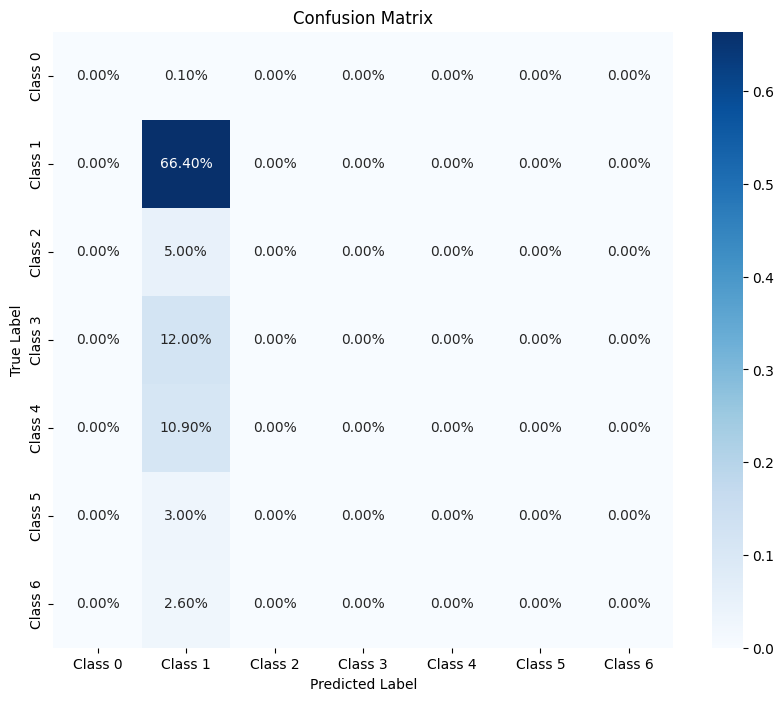

In [22]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    actual_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Map the predicted class indices to class labels
            predicted_labels.extend(np.argmax(outputs.cpu().numpy(), axis=1))
            actual_labels.extend(np.argmax(labels.cpu().numpy(), axis=1))

    return actual_labels, predicted_labels

# Evaluate the model using the test dataset
actual_labels, predicted_lables = evaluate_model(net, test_dataloader)
print(actual_labels)
print(predicted_lables)


conf_matrix = confusion_matrix(actual_labels, predicted_lables, normalize='all')

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2%", cmap="Blues", xticklabels=["Class " + str(i) for i in range(conf_matrix.shape[0])], yticklabels=["Class " + str(i) for i in range(conf_matrix.shape[0])])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()